In [70]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import random

pd.options.mode.chained_assignment = None
seed = 321

In [2]:
#reading the dataset

rice = pd.read_csv('Rice_Cammeo_Osmancik.csv')

#changing the string class to integer
rice['Class'] = rice['Class'].apply(lambda x: 1 if x == "Cammeo" else 2)

#the dataset was sorted based on the target value. This will randomize it.
rice = rice.sample(frac=1).reset_index(drop=True)



In [3]:
#adding missing values in the Area and Perimeter columns
for x in range(0, 99):
    rice['Area'][x] = np.nan
    rice['Perimeter'][x+100] = np.nan


In [57]:
#Splitting X and y
X = rice.drop(['Class'], axis=1)
y = rice['Class']

X

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
0,NaN,416.890015,172.190918,79.674118,0.886511,10819,0.694933
1,NaN,475.390015,196.856781,87.788185,0.895058,13917,0.571009
2,NaN,438.653015,174.604752,91.007248,0.853423,12504,0.615657
3,NaN,526.570007,221.612518,95.436707,0.902521,16837,0.658888
4,NaN,480.571991,205.401169,83.801277,0.912987,13699,0.650194
...,...,...,...,...,...,...,...
3805,14686.0,503.690002,212.258682,89.783691,0.906133,15003,0.552147
3806,11215.0,421.179993,179.533508,79.690178,0.896089,11373,0.582900
3807,9447.0,407.092011,173.822403,70.085938,0.915110,9698,0.582501
3808,10896.0,419.385010,174.139969,80.548363,0.886593,11145,0.589610


In [59]:
#checking to see the null values present
rice.isnull().sum()

Area                 99
Perimeter            99
Major_Axis_Length     0
Minor_Axis_Length     0
Eccentricity          0
Convex_Area           0
Extent                0
Class                 0
dtype: int64

In [7]:
#function to detect outliers based on IQR
def detect_outliers(column, index, q1, q3, iqr):
    outliers={}

    minimum = q1[column] - 1.5*iqr[column]
    maximum = q3[column] + 1.5*iqr[column]

    counter = 0
    
    for row in rice.values:        
        if(row[index] < minimum):
            outliers[counter] = row
        elif(row[index] > maximum):
            outliers[counter] = row
        counter = counter+1
            
    return outliers

In [8]:
#detecting outliers and printing the number of outliers in each column.
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

outliersArea = detect_outliers("Area", 0, Q1, Q3, IQR) 
outliersPerimeter = detect_outliers("Perimeter", 1, Q1, Q3, IQR)
outliersMajorAxisLength = detect_outliers("Major_Axis_Length", 2, Q1, Q3, IQR)
outliersMinorAxisLength = detect_outliers("Minor_Axis_Length", 3, Q1, Q3, IQR)
outliersEccentricity = detect_outliers("Eccentricity", 4, Q1, Q3, IQR)
outliersConvexArea = detect_outliers("Convex_Area", 5, Q1, Q3, IQR)
outliersExtent = detect_outliers("Extent", 6, Q1, Q3, IQR)


print("Number of outliers in the Area column: " + str(len(outliersArea)))
print("Number of outliers in the Perimeter column: " + str(len(outliersPerimeter)))
print("Number of outliers in the MajorAxisLength column: " + str(len(outliersMajorAxisLength)))
print("Number of outliers in the MinorAxisLength column: " + str(len(outliersMinorAxisLength)))
print("Number of outliers in the Eccentricity column: " + str(len(outliersEccentricity)))
print("Number of outliers in the ConvexArea column: " + str(len(outliersConvexArea)))
print("Number of outliers in the Extent column: " + str(len(outliersExtent)))

Number of outliers in the Area column: 4
Number of outliers in the Perimeter column: 0
Number of outliers in the MajorAxisLength column: 0
Number of outliers in the MinorAxisLength column: 65
Number of outliers in the Eccentricity column: 21
Number of outliers in the ConvexArea column: 3
Number of outliers in the Extent column: 0


In [9]:
#dropping null values and splitting X and y with no null values
riceNoNull = rice.dropna()
riceNoNullX = riceNoNull
riceNoNullX = riceNoNullX.drop(['Class'], axis=1)

riceNoNullY = riceNoNull['Class']

#Our dataset has empty values in the Area and Perimeter column. This code will select those attributes for two different dataframes.
riceNullArea = rice[rice['Area'].isnull()==True]

riceNullPerimeter = rice[rice['Perimeter'].isnull()==True]
riceNullPerimeter = riceNullPerimeter.reset_index(drop=True)



Attribute Description

In [10]:
rice.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
count,3711.000000,3711.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000,3810.000000
mean,12667.686338,454.070048,188.776222,86.313750,0.886871,12952.496850,0.661934,1.572178
std,1735.043752,35.508083,17.448679,5.729817,0.020818,1776.972042,0.077239,0.494828
min,7551.000000,359.100006,145.264465,59.532406,0.777233,7723.000000,0.497413,1.000000
25%,11365.500000,425.943497,174.353855,82.731695,0.872402,11626.250000,0.598862,1.000000
50%,12417.000000,448.686005,185.810059,86.434647,0.889050,12706.500000,0.645361,2.000000
75%,13954.000000,483.580002,203.550438,90.143677,0.902588,14284.000000,0.726562,2.000000
max,18913.000000,548.445984,239.010498,107.542450,0.948007,19099.000000,0.861050,2.000000


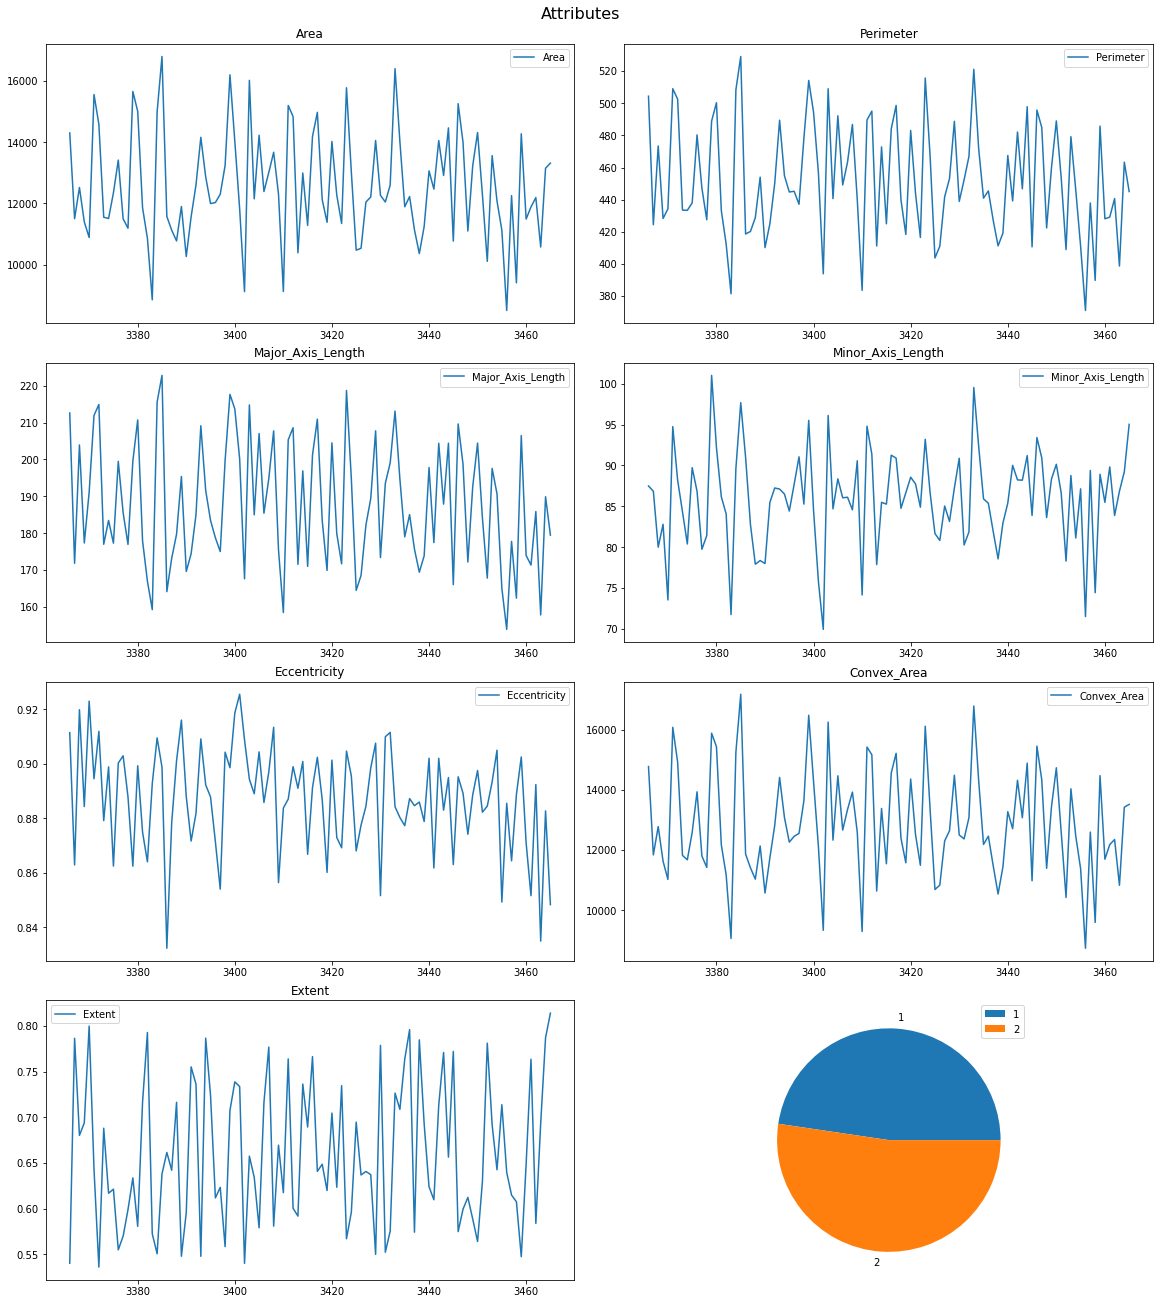

In [60]:
def plot_linear_data(df, columns, axs):
  for i in range(len(columns)):
    col = columns[i]
    pd.DataFrame(df, columns=[col]).iloc[start_loc:end_loc].plot(kind='line', ax=axs[i], title=col)


fig, axs = plt.subplots(4,2,figsize=(16,18),constrained_layout=True)
fig.suptitle("Attributes", fontsize=16)
axs = axs.flatten()

plot_linear_data(rice, ['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent'], axs)
rice.groupby(['Class']).sum().plot(kind='pie', y='Area', ax=axs[7], ylabel='')

plt.show()

We can see in each of the numeric columns that the scale of values varies significantly among all the columns. This will likely impact our model performance in later stages so we should consider some scaling techniques to rectify this.

Moreover, we can see some missing values in certain columns so we should consider some data filling technique as well.

Looking at the pie chart above we can see that the class distribution is fairly even which is a good sign for model training.

**Dealing with outliers and missing data**

As seen is previous section, we have to deal with outliers and missing data. In this section we will remove outliers and missing data then use this data later on to fill missing values and replace outlier values with better fits.

**TASK 2**

In [61]:
val_cols_names = ['Area','Perimeter','Major_Axis_Length','Minor_Axis_Length','Eccentricity','Convex_Area','Extent']
scaler_names = ['MinMax', 'Z-Score', 'Standard']
arr_scalers = [MinMaxScaler(),Normalizer(),StandardScaler()]
X_Scaled = {}

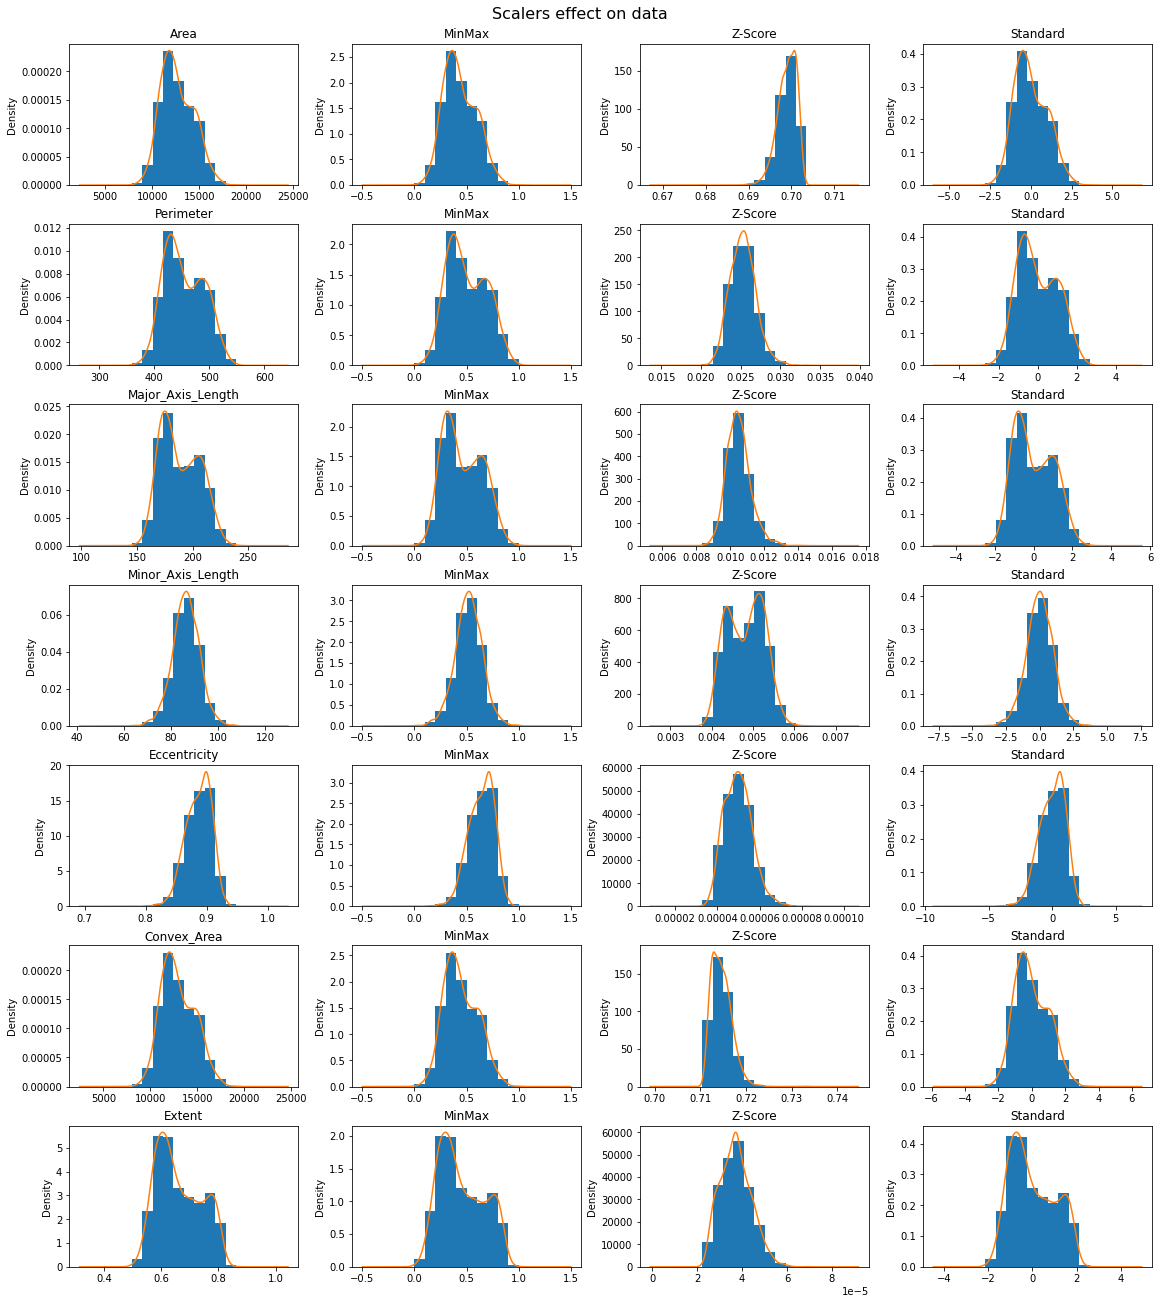

In [62]:
def plot_histograms_density_for_scalers(df, columns, fig_title, scalers, scaler_names):
    fig, axs = plt.subplots(len(columns),len(scalers)+1,figsize=(16,18),constrained_layout=True)
    fig.suptitle(fig_title, fontsize=16)
    axs = axs.flatten()
    i = 0 
    for c in columns:
        riceNoNullX[c].hist(ax=axs[i], density=True) # normalizes the density
        riceNoNullX[c].plot.density(ax=axs[i], title=c)
        i+=1
        for j in range(len(scalers)):
            df_transformed = scalers[j].fit_transform(df)
            df_transformed = pd.DataFrame(df_transformed, index=df.index, columns=df.columns)
            df_transformed[c].hist(ax=axs[i], density=True, stacked=True) # normalizes the density
            df_transformed[c].plot.density(ax=axs[i], title=scaler_names[j])
            X_Scaled[j] = df_transformed
            i+=1


plot_histograms_density_for_scalers(riceNoNullX, val_cols_names, 'Scalers effect on data', arr_scalers, scaler_names)

TASK 3

In [63]:
X = X.ffill(axis = 1)

X.isna().sum()

Area                 99
Perimeter             0
Major_Axis_Length     0
Minor_Axis_Length     0
Eccentricity          0
Convex_Area           0
Extent                0
dtype: int64

After printing the sum of null values in each column, we notice that the Area column still has 99 missing values.

The ffill pandas function does not remove all null valies.

With axis = 0, ffill copies the value of the row above it, and so if it is filling missing values in the first row, it will not be able to.

With axis = 1, ffill copies the value of the column to the left of the value, so if null value is in the first column, it will not be filled.


In [17]:
#create CV object and calculates CV score for KNN and SGD with different scalers.

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

KNN = KNeighborsClassifier(n_neighbors=3)

KNN_MinMax_CV_Score = cross_val_score(KNN, X_Scaled[0], riceNoNullY, cv=cv)
KNN_ZScore_CV_Score = cross_val_score(KNN, X_Scaled[1], riceNoNullY, cv=cv)
KNN_Standard_CV_Score = cross_val_score(KNN, X_Scaled[2], riceNoNullY, cv=cv)

SGD = SGDClassifier(max_iter=1000)

SGD_MinMax_CV_Score = cross_val_score(SGD, X_Scaled[0], riceNoNullY, cv=cv)
SGD_ZScore_CV_Score = cross_val_score(SGD, X_Scaled[1], riceNoNullY, cv=cv)
SGD_Standard_CV_Score = cross_val_score(SGD, X_Scaled[2], riceNoNullY, cv=cv)



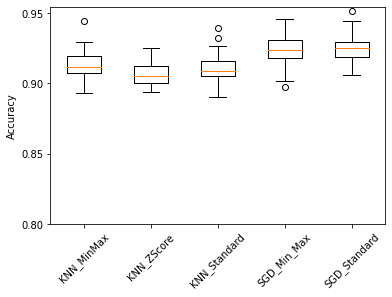

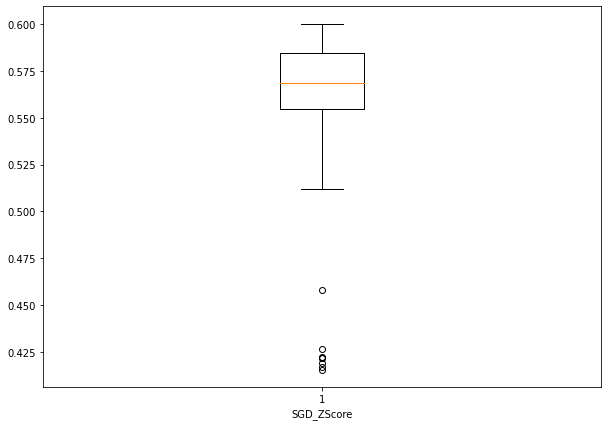

In [18]:
#Plotting the data
PlotValues = [KNN_MinMax_CV_Score, KNN_ZScore_CV_Score, KNN_Standard_CV_Score,
             SGD_MinMax_CV_Score, SGD_Standard_CV_Score]


fig, ax = plt.subplots()
ax.boxplot(PlotValues)
ax.set_ylabel('Accuracy')

plt.yticks(np.arange(0.8, 1, 0.05))
plt.xticks([1,2,3,4,5], ['KNN_MinMax', 'KNN_ZScore', 'KNN_Standard',
                           'SGD_Min_Max','SGD_Standard'], rotation=45)
plt.show()

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(SGD_ZScore_CV_Score)
plt.xlabel('SGD_ZScore')
# show plot
plt.show()

We used 5 fold Cross validation (with model accuracy as our scoring function) to determine which combination of classifier and scaler to use.

The reason we chose cross validation was because it variates between different training and testing values, so we can get a sense of how our accurate our model is with different sets of training and testing values.

Our best combination was using the SGD classifier and the Standard Scaler, as the average of the accuracies is the highest in it.

In [64]:
#creating scalers and scaling different X values

sc = StandardScaler()

X_AreaTrain = riceNoNullX.drop(columns=['Area']).reset_index(drop=True)
Y_AreaTrain = riceNoNullX['Area'].reset_index(drop=True)

X_AreaTrainScaled = sc.fit_transform(X_AreaTrain)

X_PerimeterTrain = riceNoNullX.drop(columns=['Perimeter']).reset_index(drop=True)
Y_PerimeterTrain = riceNoNullX['Perimeter'].reset_index(drop=True)

X_PerimeterTrainScaled = sc.fit_transform(X_PerimeterTrain)

X_toGetArea = riceNullArea.drop(columns=['Area','Class']) #The X to predict to get Area as Y
X_toGetPerimeter = riceNullPerimeter.drop(columns=['Perimeter', 'Class']) #The X to predict to get Perimeter as Y

X_toGetAreaScaled = sc.fit_transform(X_toGetArea)
X_toGetPerimeterScaled = sc.fit_transform(X_toGetPerimeter)

#The class column for the dataframes of the null Area and Perimeter columns
y_nullArea = riceNullArea['Class']
y_nullPerimeter = riceNullPerimeter['Class']

TO NOTE:
When we passed the scaled attributes to our functions, they were not working. It seemed that the scaler was adding infinite values to the dataset. So we used the original values (we still got good results).

In [73]:
#Fitting the KNN and predicting the Area missing values
KNNRegressor = KNeighborsRegressor(n_neighbors=5)

KNNRegressor.fit(X_AreaTrain, Y_AreaTrain)

areaFill = KNNRegressor.predict(X_toGetArea)

In [74]:
#Creating the X values datafram for Area and Class
X_toGetArea['Area'] = areaFill
X_toGetArea['Class'] = riceNullArea['Class']

In [75]:
#Fitting the KNN and predicting the Area missing values
KNNRegressor = KNeighborsRegressor(n_neighbors=5)

KNNRegressor.fit(X_PerimeterTrain, Y_PerimeterTrain)

perimeterFill = KNNRegressor.predict(X_toGetPerimeter)

In [76]:
#Creating the X values datafram for Perimeter and Class
X_toGetPerimeter['Perimeter'] = perimeterFill
X_toGetPerimeter['Class'] = riceNullPerimeter['Class']

X_toGetPerimeter

,Area,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Perimeter,Class
0,10803.0,165.223129,84.782204,0.858306,11098,0.643074,416.946802,2
1,14619.0,209.532883,89.808014,0.903489,14973,0.612314,497.975397,1
2,11339.0,177.047134,82.547409,0.884655,11533,0.592053,425.252002,2
3,13431.0,212.450607,81.185478,0.924105,13786,0.777977,475.938397,1
4,14209.0,208.822906,87.758034,0.907408,14667,0.565735,499.633600,1
...,...,...,...,...,...,...,...,...
94,13447.0,183.957581,94.458138,0.858103,13867,0.625908,478.329602,2
95,11249.0,168.608627,86.192291,0.859463,11423,0.621904,420.318005,2
96,11900.0,184.060944,83.164047,0.892105,12119,0.603877,437.257806,2
97,14947.0,214.344315,89.526901,0.908595,15364,0.562997,502.672205,1


In [77]:
#concatinating the dataframe with no null values, with the datafames with the Area and Perimeter values.
toConcat = [riceNoNull, X_toGetArea, X_toGetPerimeter]

fullDataset = pd.concat(toConcat)

fullDatasetX = fullDataset.drop(columns=['Class'])
fullDatasetY = fullDataset['Class']

In [78]:
#function to add outliers into a np array and removing the column itself and the y target variable
def get_outliers(outliers, column):
    toPredict = []
    index = 0

    for outlier in outliers:
        toAdd = outliers[outlier]
        new = np.delete(toAdd, [column, 7])
        toPredict.append(new)
        index +1
            
    return toPredict

In [79]:
#Getting the outliers in our desired form.
areaOutliersX = get_outliers(outliersArea, 0)
outliersMinorAxisLengthX = get_outliers(outliersArea, 3)
outliersEccentricityX = get_outliers(outliersArea, 4)
outliersConvexAreaX = get_outliers(outliersArea, 5)

#Splitting the data and fitting it to KNN, and predicting the values that are going to be in place of the outliers.

X_AreaTrain = fullDataset.drop(columns=['Area', 'Class']).reset_index(drop=True)
Y_AreaTrain = fullDataset['Area'].reset_index(drop=True)
KNNRegressor.fit(X_AreaTrain, Y_AreaTrain)
areaOutliersFixed = KNNRegressor.predict(areaOutliersX)


X_MinorAxisLength = fullDataset.drop(columns=['Major_Axis_Length', 'Class']).reset_index(drop=True)
Y_MinorAxisLength = fullDataset['Major_Axis_Length'].reset_index(drop=True)
KNNRegressor.fit(X_MinorAxisLength, Y_MinorAxisLength)
MinorAxisOutliersFixed = KNNRegressor.predict(outliersMinorAxisLengthX)


X_Eccentricity = fullDataset.drop(columns=['Eccentricity', 'Class']).reset_index(drop=True)
Y_Eccentricity = fullDataset['Eccentricity'].reset_index(drop=True)
KNNRegressor.fit(X_Eccentricity, Y_Eccentricity)
X_EccentricityOutliersFixed = KNNRegressor.predict(outliersEccentricityX)


X_ConvexArea = fullDataset.drop(columns=['Convex_Area', 'Class']).reset_index(drop=True)
Y_ConvexArea = fullDataset['Convex_Area'].reset_index(drop=True)
KNNRegressor.fit(X_ConvexArea, Y_ConvexArea)
ConvexAreaOutliersFixed = KNNRegressor.predict(outliersConvexAreaX)

C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [80]:
#function that replaces the outliers with the new predicted values
def fixingOutliers(outliers, newValues, column):
    index = 0
    for outlierIndex in outliers:
        fullDataset[column][outlierIndex] = newValues[index]
        index = index + 1

In [81]:
#Fixing the outliers
fixingOutliers(outliersArea, areaOutliersFixed,'Area')
fixingOutliers(outliersArea, MinorAxisOutliersFixed,'Major_Axis_Length')
fixingOutliers(outliersArea, X_EccentricityOutliersFixed,'Eccentricity')
fixingOutliers(outliersArea, ConvexAreaOutliersFixed,'Convex_Area')

We are going to use KNN CLassifier for our TASK 4

In [82]:
def select_features_modified(X, y_num, score_function,k_val):
    # configure to select all features
    sel = SelectKBest(score_func=score_function, k=k_val)
    # learn relationship from training data
    sel.fit(X, y_num)
    return sel

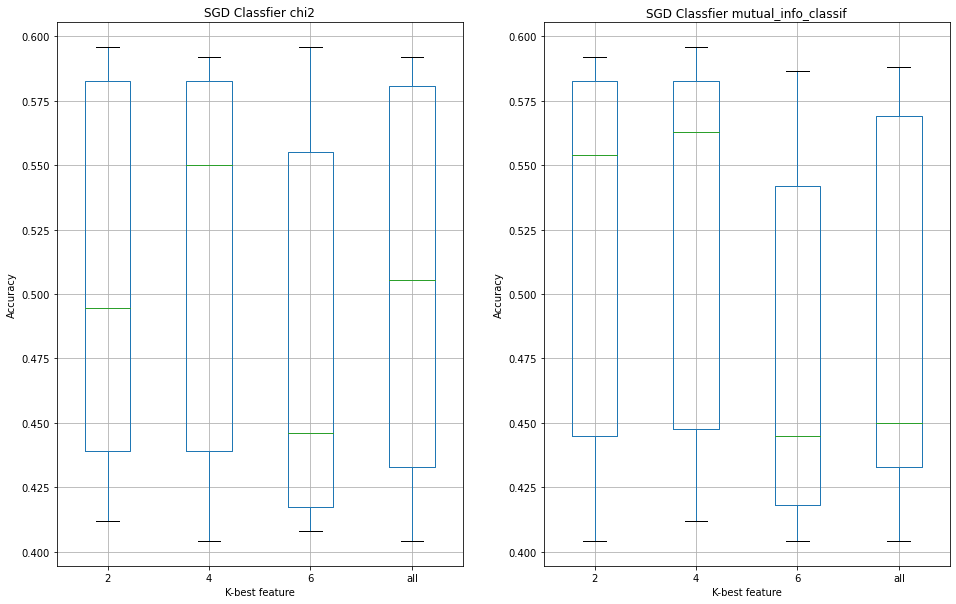

In [83]:
sel = SelectKBest()
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=321)

#using chi2 and mi scoring methods to select features
scoring_method_name= ['chi2', 'mutual_info_classif']
scoring_method= [chi2, mutual_info_classif]
k_best = [2, 4 , 6, 'all']


fig, axs = plt.subplots(1, 2, figsize=(16,10))
axs = axs.flatten()
fig_idx = 0

results = {}
for k in range(len(scoring_method)):
    score_method_inuse = scoring_method[k]
    
    for i in range(len(k_best)):
        k_val = k_best[i]
        sfs = select_features_modified(fullDatasetX, fullDatasetY, score_method_inuse, k_val)    # Selected 'K_val' best features using different scoring methods 
        
        X_sel = sfs.fit_transform(fullDatasetX, fullDatasetY)    # scaling the X 
        
        scores = cross_val_score(sgd,X_sel, fullDatasetY, scoring='accuracy', cv=cv, n_jobs=-1)    # Getting the score for the features using different classifiers
        results[f'{k_val}'] = scores
    # Box plot the combination of scoring function for different k_val and classifiers 
    df_res = pd.DataFrame(results).copy()
    df_res.boxplot(ax=axs[fig_idx])
    axs[fig_idx].set_title(f"SGD Classfier {scoring_method_name[k]}");
    axs[fig_idx].set_ylabel("Accuracy")
    axs[fig_idx].set_xlabel("K-best feature")
    fig_idx+=1

plt.show()

Looking at the comparison above we can see that we used SGDClassifier for this plot. We decided to use SGDClassifier after seeing performance comparison in the previous task.

In these graphs we can see that chi2 metric shows better accuracy for the model trained.

Moreover we can also see that selecting 2 best features performs just as good as selecting all features (the baseline model) so its better that we proceed with our data set only on the two best features which will give us better results.